In [1]:
import torch as T
import torch.nn as nn
import gym
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from IPython.display import clear_output
import os

In [2]:
class RNetwork(nn.Module):
    def __init__(self, lr, n_actions, obs_shape, chkpt_dir, name):
        super(RNetwork, self).__init__()

        self.fc1 = nn.Linear(obs_shape, 128)
        self.fc2 = nn.Linear(128, 32)
        self.gru = nn.GRUCell(32, 32)
        self.fc3 = nn.Linear(32, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.double()
        
    def forward(self, state, h = None):
        x       = F.relu(self.fc1(state))
        x       = F.relu(self.fc2(x))
        h       = F.relu(self.gru(x,h))
        actions = F.relu(self.fc3(h))
        
        return actions, h
    
    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))
        
# model = RNetwork(0.01, env.action_space.n, env.observation_space.shape[0])

## Agent

In [3]:
class Agent():
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 eps_min=0.5, eps_dec=5e-7):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.q_eval = RNetwork(lr,
                               env.action_space.n,
                               env.observation_space.shape[0],
                               chkpt_dir='tmp',
                               name='RDoubleDQN-v1' + str(self.lr))
        self.q_next = RNetwork(lr,
                               env.action_space.n,
                               env.observation_space.shape[0],
                               chkpt_dir='tmp',
                               name='RDoubleDQN-v1' + str(self.lr))
        
        self.replace_target_cnt = 50
        self.learn_step_counter = 0
        
        self.state_memory = []
        self.actions_memory = []
        self.done_memory = []
        self.reward_memory = []
    
    def clear_memory(self):
        self.state_memory = []
        self.actions_memory = []
        self.done_memory = []
        self.reward_memory = []
    
    def store_transition(self, state, action, reward, done):
        self.state_memory.append(state)
        self.actions_memory.append(action)
        self.reward_memory.append(reward)
        self.done_memory.append(done)

    def choose_action(self, observation, h):
        observation = T.tensor(observation, dtype = T.double).to(self.q_eval.device)
        actions, h = self.q_eval(observation, h)
        
        if np.random.random() > self.epsilon:
            action = T.argmax(actions).item()
        else:
            action = np.random.randint(self.n_actions)
        
        return action, h
        
    def butch_predict(self, state_sec):
        h = None
        m = []
        for i in state_sec:
            x,h = self.q_eval(i, h )
            m.append(x)
        return T.stack(m)
    
    def butch_predict_next(self, state_sec):
        h = None
        m = []
        for i in state_sec:
            x,h = self.q_eval(i, h )
            m.append(x)
        return T.stack(m)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min
    
    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()
    
    def learn(self):
        states  = T.tensor(self.state_memory, dtype = T.double).to(self.q_eval.device)
        actions = T.tensor(self.actions_memory).to(self.q_eval.device)
        dones   = T.tensor(self.done_memory).to(self.q_eval.device)
        rewards = T.tensor(self.reward_memory).to(self.q_eval.device)
        
        self.replace_target_network()
        
        self.q_eval.optimizer.zero_grad()
        
        indices = T.arange(len(self.actions_memory)).to(self.q_eval.device)
                
        q_pred = self.butch_predict(states[:-1])[indices, actions]
        q_next = self.butch_predict_next(states[1:]).max(dim=1)[0]
        q_next[dones] = 0.0

        q_target = rewards + self.gamma*q_next
        loss = self.q_eval.loss(q_target, q_pred.to(T.double)).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()

        self.decrement_epsilon()
        self.clear_memory()
        self.learn_step_counter += 1
        

## Init

In [4]:
env = gym.make('CartPole-v1')
agent = Agent(gamma = 0.97, 
              epsilon = 0.09, 
              lr = 0.001, 
              n_actions = env.action_space.n, 
              input_dims = env.action_space.shape,
              eps_min=0.05,
              eps_dec=2e-3)

/home/parkhomenko/PycharmProjects/RL/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/parkhomenko/PycharmProjects/RL/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Main

In [5]:
best_score = -np.inf
scores, eps_history, avg_score_history = [], [], []

num_games = 1000

for i in range(num_games):
    d = False
    observation = env.reset()
    agent.state_memory.append(observation)
    h = None

    score = 0

    while not d:
        a, h = agent.choose_action(observation, h)
        observation_, r, d, info = env.step(a)
        agent.store_transition(state = observation_,
                               action = a,
                               reward = r,
                               done = d)
        score += r
        observation = observation_
    agent.learn()
    
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    avg_score_history.append(avg_score)
    
    if avg_score > best_score:
        agent.save_models()
        best_score = avg_score
    
    if not bool(i%10):clear_output()
    print(i, score, avg_score, agent.epsilon)

990 136.0 78.39 0.05
991 115.0 78.16 0.05
992 43.0 77.64 0.05
993 127.0 78.51 0.05
994 35.0 78.29 0.05
995 85.0 78.39 0.05
996 45.0 77.76 0.05
997 51.0 77.33 0.05
998 34.0 77.19 0.05
999 29.0 76.71 0.05


In [6]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Num games", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

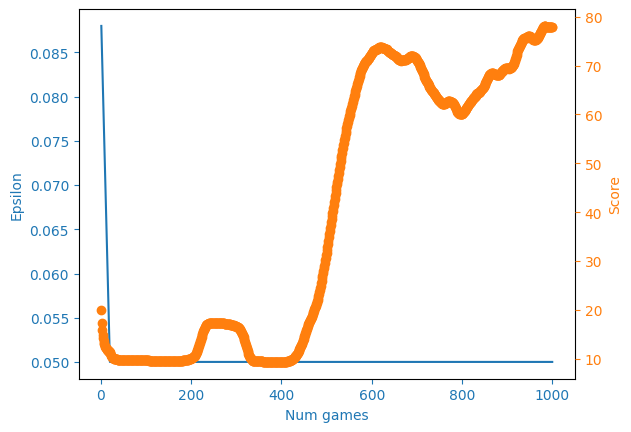

In [7]:
x = [i+1 for i in range(len(scores))]
plot_learning_curve(x, avg_score_history, eps_history, filename = 'RDoubleDQN-v1.png')